In [107]:
import datetime
from pathlib import Path

import shutil

import pandas as pd
import numpy as np
import geopandas as gp
import skimage

from pdf2image import convert_from_path, convert_from_bytes

from scipy.optimize import curve_fit

from matplotlib import pyplot as plt

## Make png of pdf

In [108]:
first_page = 13
last_page = 15

In [111]:
temp_folder = "tmp"

try:
    shutil.rmtree(temp_folder)
except Exception:
    pass

Path(temp_folder).mkdir(exist_ok=True)

tmp/0a3c2846-799d-4163-baf5-65b4db679211-13.png
tmp/0a3c2846-799d-4163-baf5-65b4db679211-14.png
tmp/0a3c2846-799d-4163-baf5-65b4db679211-15.png


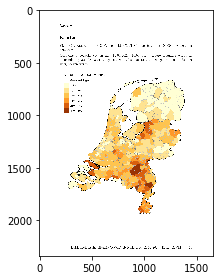

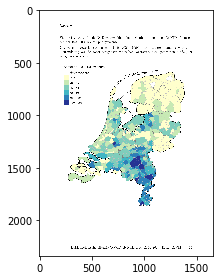

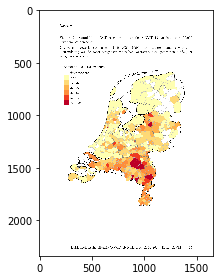

In [112]:
report_fp = "reports/COVID-19_WebSite_rapport_20200411_1125.pdf"

images = convert_from_path(
    report_fp, 
    output_folder=temp_folder, 
    fmt='png',
    first_page=first_page,
    last_page=last_page,
)

image_files = dict(zip(["Totaal", "Ziekenhuisopname", "Overleden"], sorted(Path("tmp").glob("*.png"))))

for key, image_file in image_files.items():
    
    print(image_file)
    plt.figure()
    image = skimage.io.imread(image_file)
    skimage.io.imshow(image)

## Static variables

In [165]:
DATE = datetime.date(2020, 4, 11)

# MAP = "Totaal"

# COLOR_BINS = [
#     (0, 0), 
#     (1, 70), 
#     (70, 115), 
#     (115, 185), 
#     (185, 280), 
#     (280, 440), 
#     (440, 690)
# ]

# MAP = "Ziekenhuisopname"

# COLOR_BINS = [
#     (0, 0), 
#     (1, 25), 
#     (25,40), 
#     (40,65), 
#     (65, 95), 
#     (95, 160), 
#     (160, 305)
# ]

MAP = "Overleden"

COLOR_BINS = [
    (0, 0), 
    (1, 10), 
    (10, 20), 
    (20, 30), 
    (30, 50), 
    (50, 70), 
    (70, 130)
]


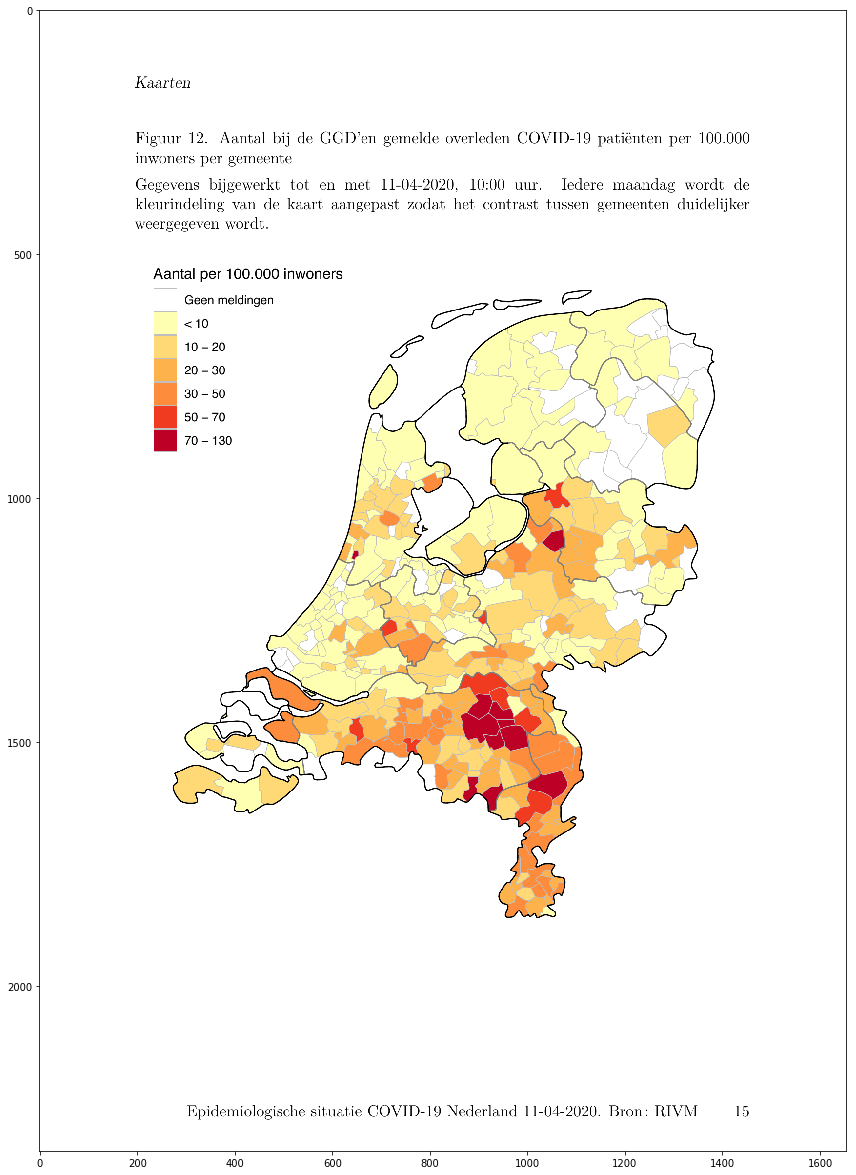

In [166]:
plt.figure(figsize=[12,20])

image = skimage.io.imread(image_files[MAP])

skimage.io.imshow(image)

## Make a bounding box for the pdf image

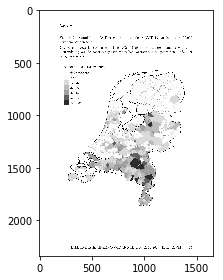

In [167]:
image = skimage.io.imread(image_files[MAP], as_gray=True)

skimage.io.imshow(image)

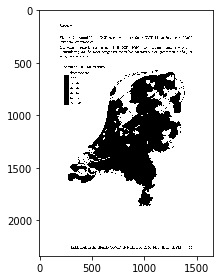

In [168]:
image_bw = image.copy()
image_bw[image_bw < 1] = 0

skimage.io.imshow(image_bw)

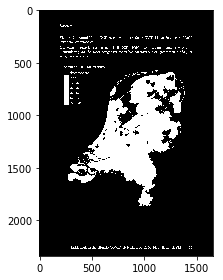

In [169]:
image_invert = 1 - image_bw

skimage.io.imshow(image_invert)

<BarContainer object of 2339 artists>

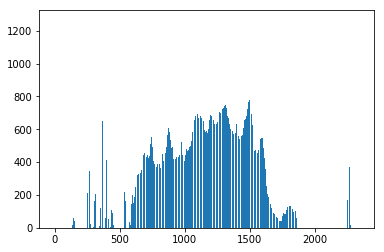

In [170]:
# check the side view
plt.bar(np.arange(image_bw.shape[0]), image_invert.sum(axis=1))

In [171]:
# let's assume the center of the page matches NL somehow
x_center = int(image_bw.shape[0]/2)
y_center = int(image_bw.shape[1]/2)

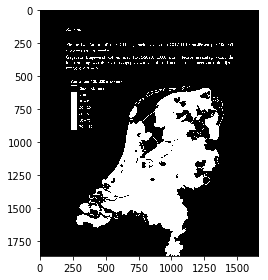

In [172]:
x_bottom = x_center+np.argmax(image_invert[x_center:, :].sum(axis=1)==0)

skimage.io.imshow(image_invert[:x_bottom, :])

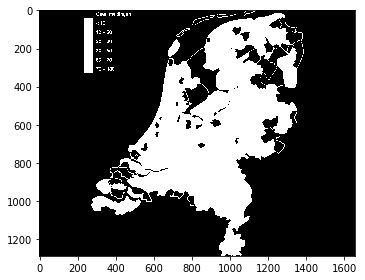

In [173]:
x_top = x_center - np.argmax(np.flipud(image_invert[0:x_center, y_center:]).sum(axis=1)==0)

skimage.io.imshow(image_invert[x_top:x_bottom, :])

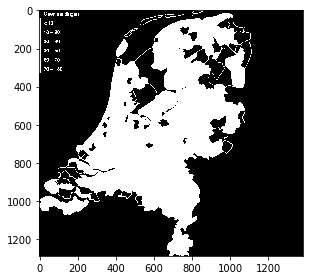

In [174]:
y_left = np.argmax(image_invert[x_center:x_bottom, :].sum(axis=0)>0)
skimage.io.imshow(image_invert[x_top:x_bottom, y_left:])

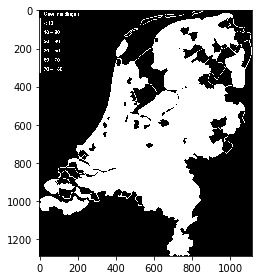

In [175]:
y_right = y_center + np.argmax(image_invert[x_top:x_bottom, y_center:].sum(axis=0)==0)

skimage.io.imshow(image_invert[x_top:x_bottom, y_left:y_right])

In [176]:
bbox_pdf = [x_top, y_left, x_bottom, y_right]
bbox_pdf

[574, 273, 1862, 1386]

## Transform center of mass to image size

In [177]:
gemeente_namen = pd.read_csv('ext/Gemeenten_alfabetisch_2019.csv', sep=";")
gemeenten = gp.read_file("ext/gemeente-2019.geojson")

gemeenten['centroid_x'] = gemeenten['geometry'].centroid.x
gemeenten['centroid_y'] = gemeenten['geometry'].centroid.y

gemeenten = gemeenten.merge(gemeente_namen[['Gemeentecode', 'Gemeentenaam', 'Provincienaam']], 
                            left_on='Gemnr',
                            right_on='Gemeentecode')

# gemeenten = gemeenten[['Gemeentenaam', 'Gemeentecode', 'centroid_x', 'centroid_y']]

# manual corrections
gemeenten.loc[gemeenten["Gemeentenaam"] == "Vlieland", "centroid_x"] = gemeenten.loc[gemeenten["Gemeentenaam"] == "Vlieland", "centroid_x"] - 3000
gemeenten.loc[gemeenten["Gemeentenaam"] == "Vlieland", "centroid_y"] = gemeenten.loc[gemeenten["Gemeentenaam"] == "Vlieland", "centroid_y"] - 3000
gemeenten.loc[gemeenten["Gemeentenaam"] == "Delfzijl", "centroid_y"] = gemeenten.loc[gemeenten["Gemeentenaam"] == "Delfzijl", "centroid_y"] - 3000
gemeenten.loc[gemeenten["Gemeentenaam"] == "Bloemendaal", "centroid_y"] = gemeenten.loc[gemeenten["Gemeentenaam"] == "Bloemendaal", "centroid_y"] + 5000
gemeenten.loc[gemeenten["Gemeentenaam"] == "Berg en Dal", "centroid_x"] = gemeenten.loc[gemeenten["Gemeentenaam"] == "Berg en Dal", "centroid_x"] - 2500
gemeenten.loc[gemeenten["Gemeentenaam"] == "Rotterdam", "centroid_x"] = gemeenten.loc[gemeenten["Gemeentenaam"] == "Rotterdam", "centroid_x"] + 11000
gemeenten.loc[gemeenten["Gemeentenaam"] == "Heerenveen", "centroid_x"] = gemeenten.loc[gemeenten["Gemeentenaam"] == "Heerenveen", "centroid_x"] - 4000
gemeenten.loc[gemeenten["Gemeentenaam"] == "Hardinxveld-Giessendam", "centroid_x"] = gemeenten.loc[gemeenten["Gemeentenaam"] == "Hardinxveld-Giessendam", "centroid_x"] - 1000
gemeenten.loc[gemeenten["Gemeentenaam"] == "Geldrop-Mierlo", "centroid_y"] = gemeenten.loc[gemeenten["Gemeentenaam"] == "Geldrop-Mierlo", "centroid_y"] + 1000
gemeenten.loc[gemeenten["Gemeentenaam"] == "Borne", "centroid_y"] = gemeenten.loc[gemeenten["Gemeentenaam"] == "Borne", "centroid_y"] + 1000
gemeenten.loc[gemeenten["Gemeentenaam"] == "Reimerswaal", "centroid_y"] = gemeenten.loc[gemeenten["Gemeentenaam"] == "Reimerswaal", "centroid_y"] - 1500




In [178]:
bbox_geojson = [
    gemeenten.bounds.minx.min(), 
    gemeenten.bounds.miny.min(), 
    gemeenten.bounds.maxx.max(), 
    gemeenten.bounds.maxy.max()
]

bbox_geojson

[323325.0, 1232816.0, 587769.0, 1539244.0]

In [179]:
a = 1/(bbox_geojson[2] - bbox_geojson[0]) * (bbox_pdf[3] - bbox_pdf[1])

gemeenten_x_rescaled = bbox_pdf[1] + (gemeenten.centroid_x - bbox_geojson[0])*a
gemeenten_y_rescaled = (image.shape[0] - (image.shape[0] - bbox_pdf[2])) - ((gemeenten.centroid_y - bbox_geojson[1])*a)

## Map geojson and pdf

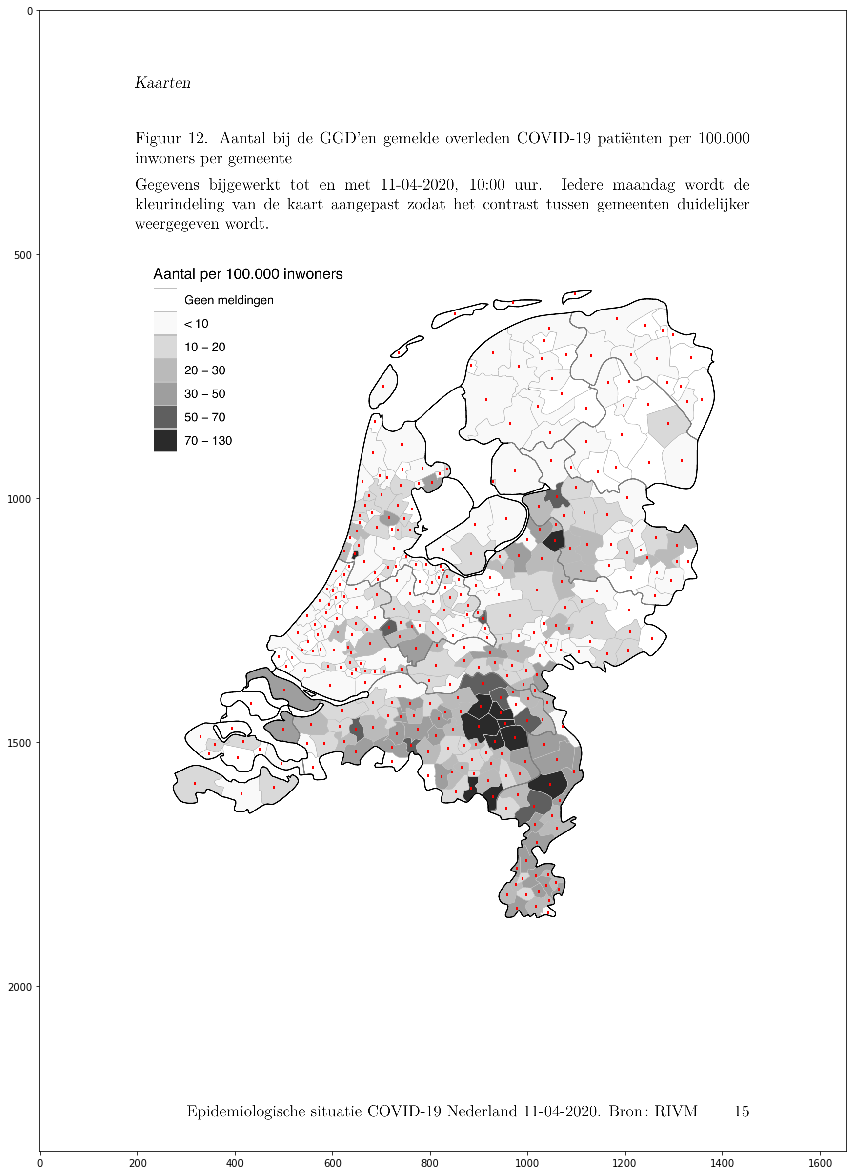

In [180]:
image_rbg = skimage.color.grey2rgb(image)

for i,x in enumerate(gemeenten_x_rescaled):
    
    image_rbg[
        int(gemeenten_y_rescaled[i]-3):int(gemeenten_y_rescaled[i]+3), 
        int(x)-2:int(x)+2, 
        0
    ] = 1 
    
    image_rbg[
        int(gemeenten_y_rescaled[i]-3):int(gemeenten_y_rescaled[i]+3), 
        int(x)-2:int(x)+2, 
        1
    ] = 0
    
    image_rbg[
        int(gemeenten_y_rescaled[i]-3):int(gemeenten_y_rescaled[i]+3), 
        int(x)-2:int(x)+2, 
        2
    ] = 0

plt.figure(figsize=[12,20])

skimage.io.imshow(image_rbg)


In [181]:
gemeenten["color_code"] = image[gemeenten_y_rescaled.astype(int), gemeenten_x_rescaled.astype(int)]

color_counts = gemeenten["color_code"].value_counts().sort_index(ascending=False)
color_counts

1.000000     51
0.978229    120
0.853822     77
0.732533     52
0.623372     35
0.374572      9
0.168244     11
Name: color_code, dtype: int64

In [182]:
# check if the colors map the values correctly
assert len(COLOR_BINS) == len(color_counts.index.values)

color_map = pd.DataFrame({
    "color_code": color_counts.index.values, 
    "Aantal_min": [x[0] for x in COLOR_BINS],
    "Aantal_max": [x[1] for x in COLOR_BINS],
})

color_map

,color_code,Aantal_min,Aantal_max
0,1.000000,0,0
1,0.978229,1,10
2,0.853822,10,20
3,0.732533,20,30
4,0.623372,30,50
5,0.374572,50,70
6,0.168244,70,130


In [183]:
gemeenten[np.round(gemeenten["color_code"], 3) == 0.523]
# gemeenten[np.round(gemeenten["color_code"], 3) == 0.548]

,OBJECTID,Gemeenten_,Shape_Leng,Shape_Area,Gemnr,geometry,centroid_x,centroid_y,Gemeentecode,Gemeentenaam,Provincienaam,color_code


In [184]:
new_data = gemeenten.merge(color_map, on="color_code")
new_data["Datum"] = str(DATE)
new_data["Type"] = MAP

new_data = new_data[["Datum", "Gemeentenaam", "Gemeentecode", "Provincienaam", "Type", "Aantal_min", "Aantal_max"]]
new_data

,Datum,Gemeentenaam,Gemeentecode,Provincienaam,Type,Aantal_min,Aantal_max
0,2020-04-11,Appingedam,3,Groningen,Overleden,0,0
1,2020-04-11,Delfzijl,10,Groningen,Overleden,0,0
2,2020-04-11,Loppersum,24,Groningen,Overleden,0,0
3,2020-04-11,Veendam,47,Groningen,Overleden,0,0
4,2020-04-11,Achtkarspelen,59,Friesland,Overleden,0,0
...,...,...,...,...,...,...,...
350,2020-04-11,Oss,828,Noord-Brabant,Overleden,50,70
351,2020-04-11,Leudal,1640,Limburg,Overleden,50,70
352,2020-04-11,Landerd,1685,Noord-Brabant,Overleden,50,70
353,2020-04-11,Sint Anthonis,1702,Noord-Brabant,Overleden,50,70


## Merge data in data file

In [185]:
def is_new_data(data):
    return data[(data["Datum"] == str(DATE)) & (data["Type"] == MAP)].shape[0] == 0


In [186]:
old_data = pd.read_csv(Path("data", "rivm_NL_covid19_municipality_range.csv"))

In [187]:
if is_new_data(old_data):
    
    full_data = old_data.append(new_data).copy()
    
    # sort full data
    full_data["Type_index"] = full_data["Type"].replace({"Totaal": 1, "Ziekenhuisopname": 2, "Overleden": 3})
    full_data.sort_values(["Datum", "Type_index", "Gemeentecode"], inplace=True)
    del full_data["Type_index"]
    
    full_data["Aantal_min"] = full_data["Aantal_min"].astype(np.float64)
    full_data["Aantal_max"] = full_data["Aantal_max"].astype(np.float64)

    full_data.to_csv(Path("data", "rivm_NL_covid19_municipality_range.csv"), index=False)

In [188]:
full_data

,Datum,Gemeentenaam,Gemeentecode,Provincienaam,Type,Aantal_min,Aantal_max
0,2020-03-26,Appingedam,3,Groningen,Overleden,0.0,0.0
1,2020-03-26,Delfzijl,10,Groningen,Overleden,0.0,0.0
2,2020-03-26,Groningen,14,Groningen,Overleden,0.0,0.0
3,2020-03-26,Loppersum,24,Groningen,Overleden,0.0,0.0
4,2020-03-26,Almere,34,Flevoland,Overleden,0.0,0.0
...,...,...,...,...,...,...,...
166,2020-04-11,Hoeksche Waard,1963,Zuid-Holland,Overleden,1.0,10.0
167,2020-04-11,Het Hogeland,1966,Groningen,Overleden,1.0,10.0
168,2020-04-11,Westerkwartier,1969,Groningen,Overleden,1.0,10.0
169,2020-04-11,Noardeast-Fryslân,1970,Friesland,Overleden,1.0,10.0
